**Package Imports**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import os
import gzip
import io
import tarfile

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
! mkdir ~/.kaggle          # Making New File Directory
!cp kaggle.json ~/.kaggle/.        #  New File Path
! chmod 600 ~/.kaggle/kaggle.json  ## Permission

! kaggle datasets download -d alessiocorrado99/animals10

100% 584M/586M [00:18<00:00, 29.9MB/s]
100% 586M/586M [00:18<00:00, 32.4MB/s]


In [5]:
! kaggle datasets download -d sahasourav17/students-anxiety-and-depression-dataset

100% 295k/295k [00:00<00:00, 857kB/s]
100% 295k/295k [00:00<00:00, 856kB/s]


**Preprocessing**


1.   What is my objective? binary classification
2.   How am I going to train this data? I'll need to tokenize the words, add LSTM or RNN layers so that theirs memory between words. Embedding will improve the model for sure. 



In [6]:
with ZipFile('students-anxiety-and-depression-dataset.zip') as f:
  print(f.namelist())
  with f.open('dataset.xlsx') as data:
    dataset = pd.read_excel(data)

dataset

['dataset.xlsx']


,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0
...,...,...
6977,I can't forget you #SpiritHadrian,0.0
6978,€ ®šæœŸâ˜†ã€'..DJ DAIKI! DJ DAIKI! DJ DAIKI!.D...,0.0
6979,Dai5y! <3,0.0
6980,tired of clowns but still hopefully tonight if...,0.0


In [ ]:
val_split        = round(len(dataset['text']) - len(dataset['text'])/5)

train_targets    = dataset['label'][0:val_split]
train_data       = dataset['text'][0:val_split]
test_targets     = dataset['label'][val_split + 1:]
test_data        = dataset['text'][val_split + 1:]


In [ ]:
train_data = [str(i) for i in train_data]
test_data  = [str(i) for i in test_data]

In [ ]:
num_words = 10000             # !0000 Words in the Text Processing Dataset
oov_token = 0                 # Words That Aren't In Training Dictionary
max_len   = 20
embedding_dim = 16

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 10000, oov_token = oov_token)
tokenizer.fit_on_texts(train_data)
train_sequenced = tokenizer.texts_to_sequences(train_data)
test_sequenced  = tokenizer.texts_to_sequences(test_data)

train_sequenced = tf.keras.utils.pad_sequences(train_sequenced, maxlen = max_len)
test_sequenced  = tf.keras.utils.pad_sequences(test_sequenced, maxlen = max_len)

**LSTM Model 1: Simple**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  activation = 'relu')),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.build()
model.summary()

**LSTM Model 2: Double Bidirectionals**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  activation = 'relu', return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation = 'relu')),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

**Recurrent Nueral Network Model**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = max_len),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.build()
model.summary()

**Gateded Recurrent Unit Model**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = max_len),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.build()
model.summary()

**Conv 1D Model**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = num_words, output_dim = 64, input_length = max_len),
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu'), # kernal is window size of examination
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.build()
model.summary()

**Left off Here adding callback for val_accuracy checks**

In [ ]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, name, logs):
    global counter 
    val_loss_history.append(logs.get('val_loss'))
    val_acc_history.append(logs.get('val_accuracy'))
    if logs.get('val_loss') > val_loss_history[counter - 1] and logs.get('val_accuracy') < val_acc_history[counter - 1]:
      print(' Validation Accuracy: ', val_loss_history[counter])
      self.model.stop_training = True

    counter += 1

In [ ]:
epochs           = 10
batch_size       = 64
val_loss_history = []
val_loss_history.append(0)
val_acc_history = []
val_acc_history.append(0)
counter          = 0 

history      = model.fit(train_sequenced, train_targets, epochs = epochs, \
                         batch_size = 64, validation_split = 0.2, callbacks = [mycallback()])
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']



Epoch 1/10
70/70 [==============================] - 2s 16ms/step - loss: 0.4610 - accuracy: 0.8270 - val_loss: 0.1555 - val_accuracy: 1.0000
Epoch 2/10
70/70 [==============================] - 1s 13ms/step - loss: 0.3169 - accuracy: 0.8718 - val_loss: 0.1024 - val_accuracy: 0.9848
Epoch 3/10
70/70 [==============================] - 1s 14ms/step - loss: 0.0828 - accuracy: 0.9767 - val_loss: 0.0675 - val_accuracy: 0.9776
Epoch 4/10
70/70 [==============================] - 1s 13ms/step - loss: 0.0228 - accuracy: 0.9944 - val_loss: 0.0807 - val_accuracy: 0.9714
Epoch 5/10
70/70 [==============================] - 1s 13ms/step - loss: 0.0091 - accuracy: 0.9982 - val_loss: 0.0707 - val_accuracy: 0.9812
Epoch 6/10
70/70 [==============================] - 1s 13ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.1213 - val_accuracy: 0.9633


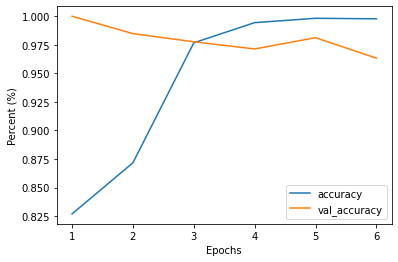

In [ ]:
epo_plot = range(1, len(val_acc_history))
plt.plot(epo_plot, accuracy, label = 'accuracy')
plt.plot(epo_plot, val_accuracy, label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Percent (%)')
plt.legend()

In [ ]:
model.evaluate(test_sequenced, test_targets, batch_size = 64, verbose = 1)

22/22 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.9448


[nan, 0.9448028802871704]